<a href="https://colab.research.google.com/github/td-02/Wings-of-Wisdom/blob/main/Wings_of_wisdom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download the folder and extract the files**

- Run this immediately when you start the test.
- Once the execution is successful, there will be train.csv, test.csv and images folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/HV-AI-2024.zip /content/HV-AI-2024.zip

In [ ]:
#!pip install gdown
#!gdown --id 1t57m_n_v_C7CR-w4bnWi33bhXbS2vWMU
!unzip HV-AI-2024.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/
!rm -rf /content/HV-AI-2024
!rm /content/HV-AI-2024.zip
!rm -rf /content/sample_data
from google.colab import output
output.clear()

# **Helper Functions**

In [ ]:
import requests

def send_results_for_evaluation(name, csv_file, email):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name':name}
    response = requests.post(url, files=files, data=data)
    return response.json()



# **Plot Sample Images**

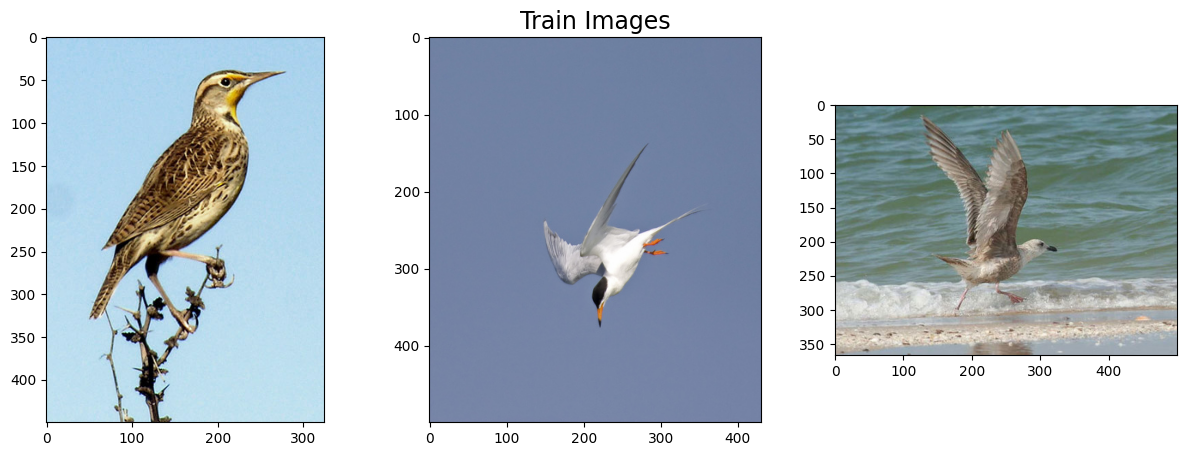

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob


train_images = glob('images/train/*.jpg')[0:3]
test_images = glob('images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

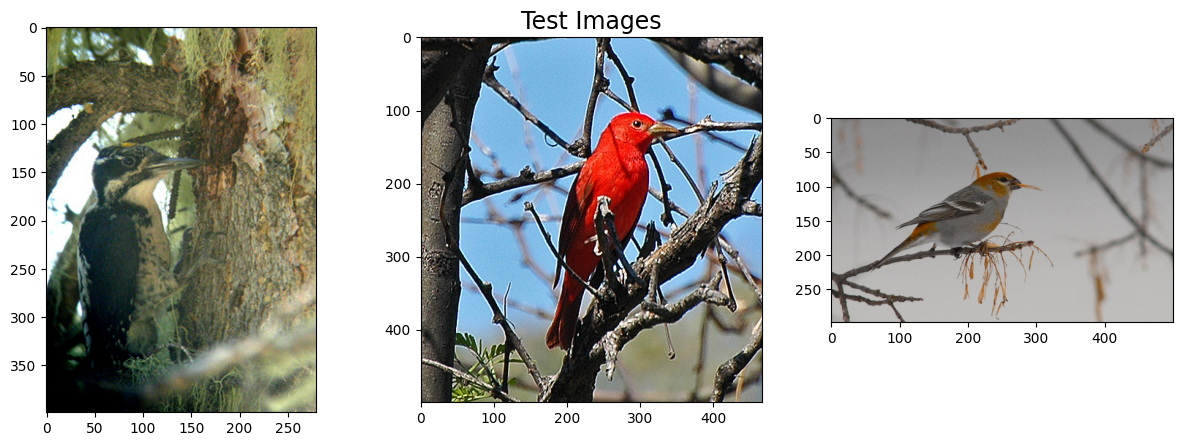

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

# **Load/Preprocess **data****

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.img_labels.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomImageDataset(csv_file='/content/train.csv', img_dir='/content', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 200)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

torch.save(model.state_dict(), 'model.pth')

cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lea

Epoch 1/10, Loss: 4.463577136080316
Epoch 2/10, Loss: 2.955753561030043
Epoch 3/10, Loss: 2.079632486434693
Epoch 4/10, Loss: 1.4222771534894376
Epoch 5/10, Loss: 0.9896473583388836
Epoch 6/10, Loss: 0.6192631167458728
Epoch 7/10, Loss: 0.3516733805312121
Epoch 8/10, Loss: 0.2091432796751565
Epoch 9/10, Loss: 0.14685137139910714
Epoch 10/10, Loss: 0.09572731890775105


In [ ]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved to 'model.pth'")

Model saved to 'model.pth'


# **Model initialization/Training**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

# Define your custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.img_labels.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the full dataset
data = pd.read_csv('/content/train.csv')

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['class'])

# Save the splits to CSV files
train_df.to_csv('/content/train_split.csv', index=False)
val_df.to_csv('/content/val_split.csv', index=False)

# Create datasets and dataloaders
train_dataset = CustomImageDataset(csv_file='/content/train_split.csv', img_dir='/content', transform=train_transform)
val_dataset = CustomImageDataset(csv_file='/content/val_split.csv', img_dir='/content', transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the pre-trained EfficientNet model
model = models.efficientnet_b0(weights='DEFAULT')

# Adjust the final layer to match the number of classes
num_classes = 200
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with validation and data augmentation
num_epochs = 10  # Set the number of epochs as needed

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val_predictions / total_val_predictions

    # Step the learning rate scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training complete!")


Epoch 1/10, Loss: 4.0849, Accuracy: 0.1285, Val Loss: 2.5129, Val Accuracy: 0.3436
Epoch 2/10, Loss: 2.4766, Accuracy: 0.3750, Val Loss: 1.7681, Val Accuracy: 0.5113
Epoch 3/10, Loss: 1.9406, Accuracy: 0.5030, Val Loss: 1.4350, Val Accuracy: 0.6063
Epoch 4/10, Loss: 1.3973, Accuracy: 0.6534, Val Loss: 1.0004, Val Accuracy: 0.7148
Epoch 5/10, Loss: 1.1475, Accuracy: 0.7205, Val Loss: 0.9371, Val Accuracy: 0.7465
Epoch 6/10, Loss: 1.0963, Accuracy: 0.7322, Val Loss: 0.8903, Val Accuracy: 0.7540
Epoch 7/10, Loss: 1.0063, Accuracy: 0.7612, Val Loss: 0.8936, Val Accuracy: 0.7581
Epoch 8/10, Loss: 1.0030, Accuracy: 0.7591, Val Loss: 0.8889, Val Accuracy: 0.7581
Epoch 9/10, Loss: 0.9978, Accuracy: 0.7597, Val Loss: 0.8820, Val Accuracy: 0.7615
Epoch 10/10, Loss: 0.9716, Accuracy: 0.7666, Val Loss: 0.8779, Val Accuracy: 0.7573
Training complete!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

# Define your custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.img_labels.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the full dataset
data = pd.read_csv('/content/train.csv')

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['class'])

# Save the splits to CSV files
train_df.to_csv('/content/train_split.csv', index=False)
val_df.to_csv('/content/val_split.csv', index=False)

# Create datasets and dataloaders
train_dataset = CustomImageDataset(csv_file='/content/train_split.csv', img_dir='/content', transform=train_transform)
val_dataset = CustomImageDataset(csv_file='/content/val_split.csv', img_dir='/content', transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the pre-trained EfficientNet-B1 model
model = models.efficientnet_b1(weights='DEFAULT')

# Adjust the final layer to match the number of classes
num_classes = 200
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight_decay
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop with validation
num_epochs = 25  # Set the total number of epochs
best_val_accuracy = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val_predictions / total_val_predictions

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training complete!")


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 41.1MB/s]


Epoch 1/25, Loss: 4.3126, Accuracy: 0.0995, Val Loss: 2.6861, Val Accuracy: 0.2944
Epoch 2/25, Loss: 2.8002, Accuracy: 0.2970, Val Loss: 1.8662, Val Accuracy: 0.4712
Epoch 3/25, Loss: 2.2197, Accuracy: 0.4344, Val Loss: 1.6036, Val Accuracy: 0.5563
Epoch 4/25, Loss: 1.9570, Accuracy: 0.4951, Val Loss: 1.3612, Val Accuracy: 0.6163
Epoch 5/25, Loss: 1.6913, Accuracy: 0.5585, Val Loss: 1.1828, Val Accuracy: 0.6580
Epoch 6/25, Loss: 1.5400, Accuracy: 0.6033, Val Loss: 1.1968, Val Accuracy: 0.6664
Epoch 7/25, Loss: 1.4879, Accuracy: 0.6163, Val Loss: 1.1734, Val Accuracy: 0.6672
Epoch 8/25, Loss: 1.3537, Accuracy: 0.6417, Val Loss: 1.1512, Val Accuracy: 0.6714
Epoch 9/25, Loss: 1.2615, Accuracy: 0.6647, Val Loss: 1.0831, Val Accuracy: 0.6872
Epoch 10/25, Loss: 1.2292, Accuracy: 0.6728, Val Loss: 1.0944, Val Accuracy: 0.6889
Epoch 11/25, Loss: 1.1759, Accuracy: 0.6932, Val Loss: 1.1720, Val Accuracy: 0.6697
Epoch 12/25, Loss: 1.1195, Accuracy: 0.7051, Val Loss: 1.0992, Val Accuracy: 0.6881
E

In [ ]:
# After training your model
torch.save(model.state_dict(), 'efficientnet_b0_model.pth')


# **Model Inference**

In [ ]:
import torch
import pandas as pd
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define a test dataset class
class TestImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_path

# Define the transformations for test images
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset and create a DataLoader
test_dataset = TestImageDataset(img_dir='/content/images/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(weights='DEFAULT')
num_classes = 200
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load('/content/efficientnet_b0_model.pth'))
model = model.to(device)
model.eval()

# Lists to store results
img_paths = []
predicted_labels = []
confidence_scores = []

# Make predictions
with torch.no_grad():
    for inputs, paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Get predicted labels and confidence scores
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidences, predicted = torch.max(probs, 1)

        # Store results
        img_paths.extend(paths)
        predicted_labels.extend(predicted.cpu().numpy())
        confidence_scores.extend(confidences.cpu().numpy())

# Create a DataFrame and save to CSV
results_df = pd.DataFrame({
    'path': img_paths,
    'predicted_label': predicted_labels,
    'confidence_score': confidence_scores
})

results_df.to_csv('/content/test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv' successfully!")


Predictions saved to 'test_predictions.csv' successfully!


In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

def test_inference(output_file):
    """
    This function is used to save the csv file with predictions from a test dataset.

    Parameters:
    - output_file (str): Name of the output CSV file to save predictions.
    - email (str): Email address to send the results.

    Format of CSV file (Follow the header names strictly):

            path (str)              predicted_label(int)   confidence_score(float)
        images/test/xx.jpg                  1                         0.6
        images/test/yy.jpg                  2                         0.9
                :                           :                          :
                :                           :                          :

    Once the prediction file is saved as shown in the above format, you can further analyze the predictions.

    Caution: Check your paths and model before executing the cell.
    """

    # Load your trained model
    model_path = '/content/checkpoint.pth'  # Replace with your model path
    model = load_model(model_path)

    # Directory containing test images
    test_dir = '/content/images/test'  # Replace with your test directory path

    # Initialize lists to store results
    paths = []
    predicted_labels = []
    confidence_scores = []

    # Get list of test image paths
    test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]
    print(test_image_paths)
    # Process each test image
    for img_path in test_image_paths:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalize image
        prediction = model.predict(img_array)[0]
        predicted_class = np.argmax(prediction)
        confidence_score = np.max(prediction)

        # Append results
        paths.append(img_path)
        predicted_labels.append(predicted_class)
        confidence_scores.append(confidence_score)

    # Create DataFrame
    results_df = pd.DataFrame({
        'path': paths,
        'predicted_label': predicted_labels,
        'confidence_score': confidence_scores
    })

    # Save results to CSV
    results_df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

    # Send results for evaluation



# ***Test Inference***

In [ ]:
# Define the test dataset class
class CustomTestImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_path  # Return image and path

# Transformation for test data (should match the training transformation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize test dataset and data loader
test_dataset = CustomTestImageDataset(csv_file='/content/test.csv', img_dir='/content', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)  # Assuming you load your trained model here
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 200)  # Adjust based on your number of classes
model = model.to(device)
model.load_state_dict(torch.load('model.pth'))  # Load the trained weights

# Set model to evaluation mode
model.eval()

# Lists to store predictions
# Lists to store predictions
predicted_labels = []
confidence_scores = []
paths = []

# Iterate over test data
for inputs, batch_paths in test_loader:
    inputs = inputs.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence = torch.max(probs, dim=1)[0]

    # Convert tensors to lists
    predicted_labels.extend(preds.cpu().numpy())
    confidence_scores.extend(confidence.cpu().numpy())
    paths.extend(batch_paths)  # Extend with batch_paths

# Prepare results DataFrame
results_df = pd.DataFrame({
    'path': paths,
    'predicted_label': predicted_labels,
    'confidence_score': confidence_scores
})



# Save results to CSV
results_df.to_csv('/content/predictions_new.csv', index=False, columns=['path', 'predicted_label', 'confidence_score'])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.1.weight", "fc.1.bias". 

In [ ]:
print(send_results_for_evaluation('Tapesh Das', 'test.csv', 'tm5139@srmist.edu.in'))

{'overall_accuracy (%)': 46.13393, 'max_accuracy_class': 17, 'max_accuracy (%)': 93.33333, 'min_accuracy_class': 106, 'min_accuracy (%)': 6.66667}


In [ ]:
import torch
import pandas as pd
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

# Define your custom dataset class for test images
class TestImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return img_path, image

# Define the transformations for the test set
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader for test images
test_dataset = TestImageDataset(img_dir='/content/images/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define the device and load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 200)
model = model.to(device)
model.load_state_dict(torch.load('/content/model.pth'))
model.eval()

# Prepare for storing results
results = []

# Make predictions
with torch.no_grad():
    for img_paths, images in test_loader:
        images = images.to(device)
        outputs = model(images)
        confidences, predicted_labels = torch.max(outputs, 1)

        for img_path, confidence, predicted_label in zip(img_paths, confidences.cpu().numpy(), predicted_labels.cpu().numpy()):
            results.append({
                'path': img_path,
                'predicted_label': int(predicted_label),
                'confidence_score': float(confidence)
            })

# Save results to a CSV file
df = pd.DataFrame(results)
df.to_csv('/content/pred.csv', index=False)

print("Predictions saved to 'test_predictions.csv'")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predictions saved to 'test_predictions.csv'
